In [1]:
import pandas as pd

df = pd.read_csv('../dados/acordaos-unicos-filtrados-6000.csv', sep = '|')
df['filtrado_6000']=df['filtrado_6000'].astype(str)
df.head()

,acordao,areas,filtrado_6000
0,297/2016-P,Responsabilidade,tribunal conta união tc grupo classe plenário ...
1,366/2016-P,Finanças Públicas,tribunal conta união tc grupo classe ii plenár...
2,944/2016-P,Responsabilidade,tribunal conta união tc grupo classe plenário ...
3,30/2016-P,Direito Processual,tribunal conta união tc grupo classe plenário ...
4,55/2016-P,Pessoal,wania lucia pasquarelli nascimentotcuwania luc...


In [2]:
df.shape

(9739, 3)

In [3]:
from sklearn.preprocessing import LabelBinarizer

areas = df.groupby(['areas']).groups.keys()
lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
lbArea.classes_

array(['Competência do TCU', 'Contrato Administrativo', 'Convênio',
       'Desestatização', 'Direito Processual', 'Finanças Públicas',
       'Gestão Administrativa', 'Licitação', 'Pessoal',
       'Responsabilidade'], dtype='<U23')

In [4]:
y = lbArea.transform(df['areas'])
y.shape

(9739, 10)

In [5]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 100000
limite_texto = 6000
dim_vetor = 50

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['filtrado_6000'])

sequences = tokenizer.texts_to_sequences(df['filtrado_6000'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 95423 unique tokens.


In [8]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > 40000), sum(pd.Series(lens) > 40000)/len(lens)

(1, 3419.08563507547, 6076, 1850.8483979056787, 9739, 0, 0.0)

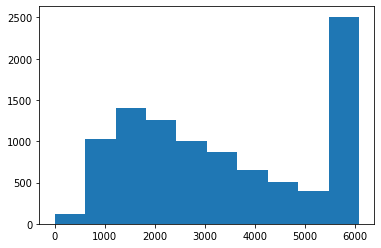

In [9]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()
plt.show()

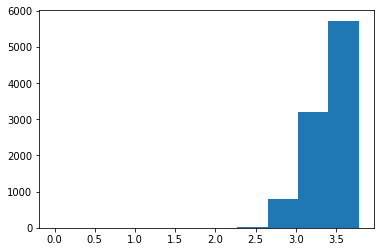

In [10]:
plt.hist(np.log10(lens))
plt.show()
plt.show()

In [11]:
np.percentile(lens, 25), np.percentile(lens, 50), np.percentile(lens, 75), np.percentile(lens, 90), np.percentile(lens, 95)

(1765.0, 3075.0, 5577.0, 5998.0, 6000.0)

In [12]:
np.mean(np.log10(lens)), 10**np.mean(np.log10(lens)), np.std(np.log10(lens)), (np.mean(np.log10(lens)) + 2*np.std(np.log10(lens))), 10**(np.mean(np.log10(lens)) + 2*np.std(np.log10(lens)))

(3.4540196127087723,
 2844.5895660154088,
 0.2856037995915741,
 4.02522721189192,
 10598.08044933771)

In [13]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (9739, 6000)


In [14]:
x.shape, y.shape

((9739, 6000), (9739, 10))

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W0312 00:00:05.888270 140064958707520 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0312 00:00:05.907567 140064958707520 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0312 00:00:05.909243 140064958707520 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0312 00:00:05.937577 140064958707520 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6000, 50)          5000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 300000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               153600512 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total para

In [16]:
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W0312 00:00:12.355640 140064958707520 deprecation.py:323] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7791 samples, validate on 1948 samples
Epoch 1/20
7791/7791 [==============================] - 52s 7ms/step - loss: 1.3982 - categorical_accuracy: 0.5327 - val_loss: 1.1908 - val_categorical_accuracy: 0.5739
Epoch 2/20
7791/7791 [==============================] - 45s 6ms/step - loss: 0.4909 - categorical_accuracy: 0.8419 - val_loss: 1.2186 - val_categorical_accuracy: 0.6027
Epoch 3/20
7791/7791 [==============================] - 46s 6ms/step - loss: 0.0738 - categorical_accuracy: 0.9788 - val_loss: 1.5225 - val_categorical_accuracy: 0.5888
Epoch 4/20
7791/7791 [==============================] - 46s 6ms/step - loss: 0.0189 - categorical_accuracy: 0.9953 - val_loss: 1.7390 - val_categorical_accuracy: 0.5970
Epoch 5/20
7791/7791 [==============================] - 46s 6ms/step - loss: 0.0084 - categorical_accuracy: 0.9977 - val_loss: 1.9465 - val_categorical_accuracy: 0.6022
Epoch 6/20
7791/7791 [==============================] - 46s 6ms/step - loss: 0.0062 - categorical_accuracy: